In [14]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from huggingface_hub import hf_hub_download
import warnings
warnings.filterwarnings("ignore")

!set HF_HUB_DISABLE_SYMLINKS_WARNING=true

# Load dataset
dataset = 'reg_cat/analcatdata_supreme.csv'
REPO_ID = "inria-soda/tabular-benchmark"
data = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=dataset, repo_type="dataset")
)

X = data.drop('Log_exposure', axis=1)
y = data['Log_exposure']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [15]:

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LagLlama(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dropout):
        super(LagLlama, self).__init__()
        self.encoder = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.decoder = nn.Linear(embed_dim, input_dim)
        self.fc = nn.Linear(input_dim, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.unsqueeze(1)  # Add a sequence dimension
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.squeeze(1)  # Remove the sequence dimension
        x = self.decoder(x)
        x = self.fc(x)
        return x

def objective(trial):
    # Define hyperparameters to tune
    num_heads = trial.suggest_int('num_heads', 2, 8)
    embed_dim = trial.suggest_int('embed_dim', num_heads * 8, num_heads * 32, step=num_heads * 8)
    num_layers = trial.suggest_int('num_layers', 2, 6)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Initialize the model
    input_dim = X_train.shape[1]
    model = LagLlama(input_dim, embed_dim, num_heads, num_layers, dropout)
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor.to(device))
        rmse = torch.sqrt(criterion(predictions, y_test_tensor.to(device))).item()
    
    return rmse

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)


[I 2024-06-03 18:06:49,972] A new study created in memory with name: no-name-08c2809a-94e4-450f-a516-f54a6d354150
[I 2024-06-03 18:08:20,475] Trial 0 finished with value: 0.2743501365184784 and parameters: {'num_heads': 8, 'embed_dim': 192, 'num_layers': 4, 'dropout': 0.25098700828723836, 'learning_rate': 0.0008292793869030677}. Best is trial 0 with value: 0.2743501365184784.
[I 2024-06-03 18:09:13,561] Trial 1 finished with value: 0.1591539829969406 and parameters: {'num_heads': 7, 'embed_dim': 112, 'num_layers': 3, 'dropout': 0.16393583086969032, 'learning_rate': 6.187452393398757e-05}. Best is trial 1 with value: 0.1591539829969406.
[I 2024-06-03 18:10:20,608] Trial 2 finished with value: 0.35376209020614624 and parameters: {'num_heads': 7, 'embed_dim': 112, 'num_layers': 4, 'dropout': 0.4061379627146626, 'learning_rate': 1.4245524557709359e-05}. Best is trial 1 with value: 0.1591539829969406.
[I 2024-06-03 18:10:51,940] Trial 3 finished with value: 0.5031148195266724 and parameters

Best hyperparameters:  {'num_heads': 7, 'embed_dim': 112, 'num_layers': 4, 'dropout': 0.14476189931777117, 'learning_rate': 0.00010631571227816024}
Best RMSE:  0.14525149762630463


In [7]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error

# # Load dataset
# dataset = 'reg_cat/analcatdata_supreme.csv'
# REPO_ID = "inria-soda/tabular-benchmark"
# data = pd.read_csv(hf_hub_download(repo_id=REPO_ID, filename=dataset, repo_type="dataset"))
# X = data.drop('Log_exposure', axis=1)
# y = data['Log_exposure']

# # Standardize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Train XGBoost model
# xgb_model = xgb.XGBRegressor()
# xgb_model.fit(X_train, y_train)

# # Predict and evaluate
# predictions = xgb_model.predict(X_test)
# xgboost_rmse = mean_squared_error(y_test, predictions, squared=False)
# print(f"XGBoost RMSE: {xgboost_rmse}")




XGBoost RMSE: 0.08822682636989307


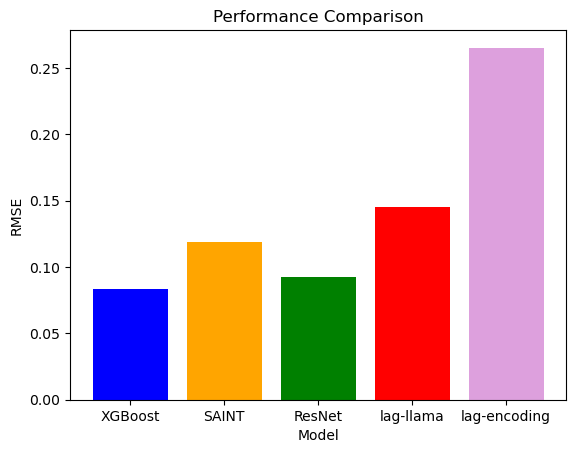

Best XGBOOST hyperparameters:  {'n_estimators': 133, 'max_depth': 8, 'learning_rate': 0.11334686113587526, 'gamma': 0.009860828607778014, 'min_child_weight': 9, 'subsample': 0.9963943210297486, 'colsample_bytree': 0.6793447846109051}


Best SAINT hyperparameters:  {'num_heads': 6, 'embed_dim': 96, 'num_layers': 5, 'dropout': 0.10640181013905547, 'learning_rate': 6.376830055102888e-05}


Best ResNet hyperparameters:  {'hidden_dim': 144, 'num_blocks': 3, 'dropout': 0.48672492461773437, 'learning_rate': 0.005133179138771948}


Best Lag-Llama hyperparameters:  {'num_heads': 7, 'embed_dim': 112, 'num_layers': 4, 'dropout': 0.14476189931777117, 'learning_rate': 0.00010631571227816024}


Best trans lag hyperparameters:  {'num_heads': 4, 'embed_dim': 64, 'num_layers': 5, 'dropout': 0.2565767626966763, 'learning_rate': 4.5915253774484096e-05}


In [18]:
import matplotlib.pyplot as plt

# Ensure that the RMSE values for all models are obtained
# Note: The variables `saint_study`, `resnet_study`, and `transformer_study` should be already defined
v1= 0.1192101240158081


# Visualize performance comparison
model_names = ['XGBoost', 'SAINT', 'ResNet', 'lag-llama','lag-encoding']
rmse_values = [0.083567666534383, v1, 0.09278280287981033, study.best_value, 0.26530590653419495]

plt.bar(model_names, rmse_values, color=['blue', 'orange', 'green', 'red','plum'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Performance Comparison')
plt.show()
saint_study= {'num_heads': 6, 'embed_dim': 96, 'num_layers': 5, 'dropout': 0.10640181013905547, 'learning_rate': 6.376830055102888e-05}
resnet_study= {'hidden_dim': 144, 'num_blocks': 3, 'dropout': 0.48672492461773437, 'learning_rate': 0.005133179138771948}
transformer_study= {'num_heads': 7,
 'embed_dim': 224,
 'num_layers': 6,
 'dropout': 0.10440143355537192,
 'learning_rate': 1.0316558759517638e-05}
x = {'num_heads': 4, 'embed_dim': 64, 'num_layers': 5, 'dropout': 0.2565767626966763, 'learning_rate': 4.5915253774484096e-05}
# Visualize best hyperparameters for each model
xg = {'n_estimators': 133, 'max_depth': 8, 'learning_rate': 0.11334686113587526, 'gamma': 0.009860828607778014, 'min_child_weight': 9, 'subsample': 0.9963943210297486, 'colsample_bytree': 0.6793447846109051}
print("Best XGBOOST hyperparameters: ", xg)
print("\n")
print("Best SAINT hyperparameters: ", saint_study)
print("\n")
print("Best ResNet hyperparameters: ", resnet_study)
print("\n")
# print("Best Transformer hyperparameters: ", transformer_study)
print("Best Lag-Llama hyperparameters: ", study.best_params)
print("\n")
print("Best trans lag hyperparameters: ", x)
mod 
(yi -y)

10
(1- 10) 0